In [1]:
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
from scipy.stats import linregress
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#%matplotlib inline
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1,
    palette="deep"
)

# Paths
HERE = Path(".").absolute()
ROOT = HERE.parent.parent
FIGS = ROOT/"figs"
FIGS.mkdir(exist_ok=True)

# Main parameters
COLORS = np.array(["#7aa063", "#c86b57", "#9d6ebd"])
GRAY = "#efefef"
FSIZE = 16
FWEIGHT = "bold"
FONTS = dict(fontsize=FSIZE, fontweight=FWEIGHT)

METHODS = ("balance", "k_balance", "node_balance")
NETWORKS = {
    "soc-sign-epinions": "Epinions",
    "slashdot_zoo": "Slashdot",
    "elec": "Wikipedia"
}

with open(HERE/"efficiency.pkl", "rb") as fh:
    data = pickle.load(fh)

data["name"] = pd.Categorical(data["name"].map(NETWORKS), NETWORKS.values())

In [2]:
suffix = "_s"
sdata = data \
    .set_index(["name", "n_nodes", "n_edges", "m"]) \
    .pipe(lambda df: df.loc[:, [ c for c in df.columns if c.endswith(suffix) ]]) \
    .rename(columns={ m+suffix: m for m in METHODS }) \
    .reset_index(drop=False)

suffix = "_w"
wdata = data \
    .set_index(["name", "n_nodes", "n_edges", "m"]) \
    .pipe(lambda df: df.loc[:, [ c for c in df.columns if c.endswith(suffix) ]]) \
    .rename(columns={ m+suffix: m for m in METHODS })  \
    .reset_index(drop=False)

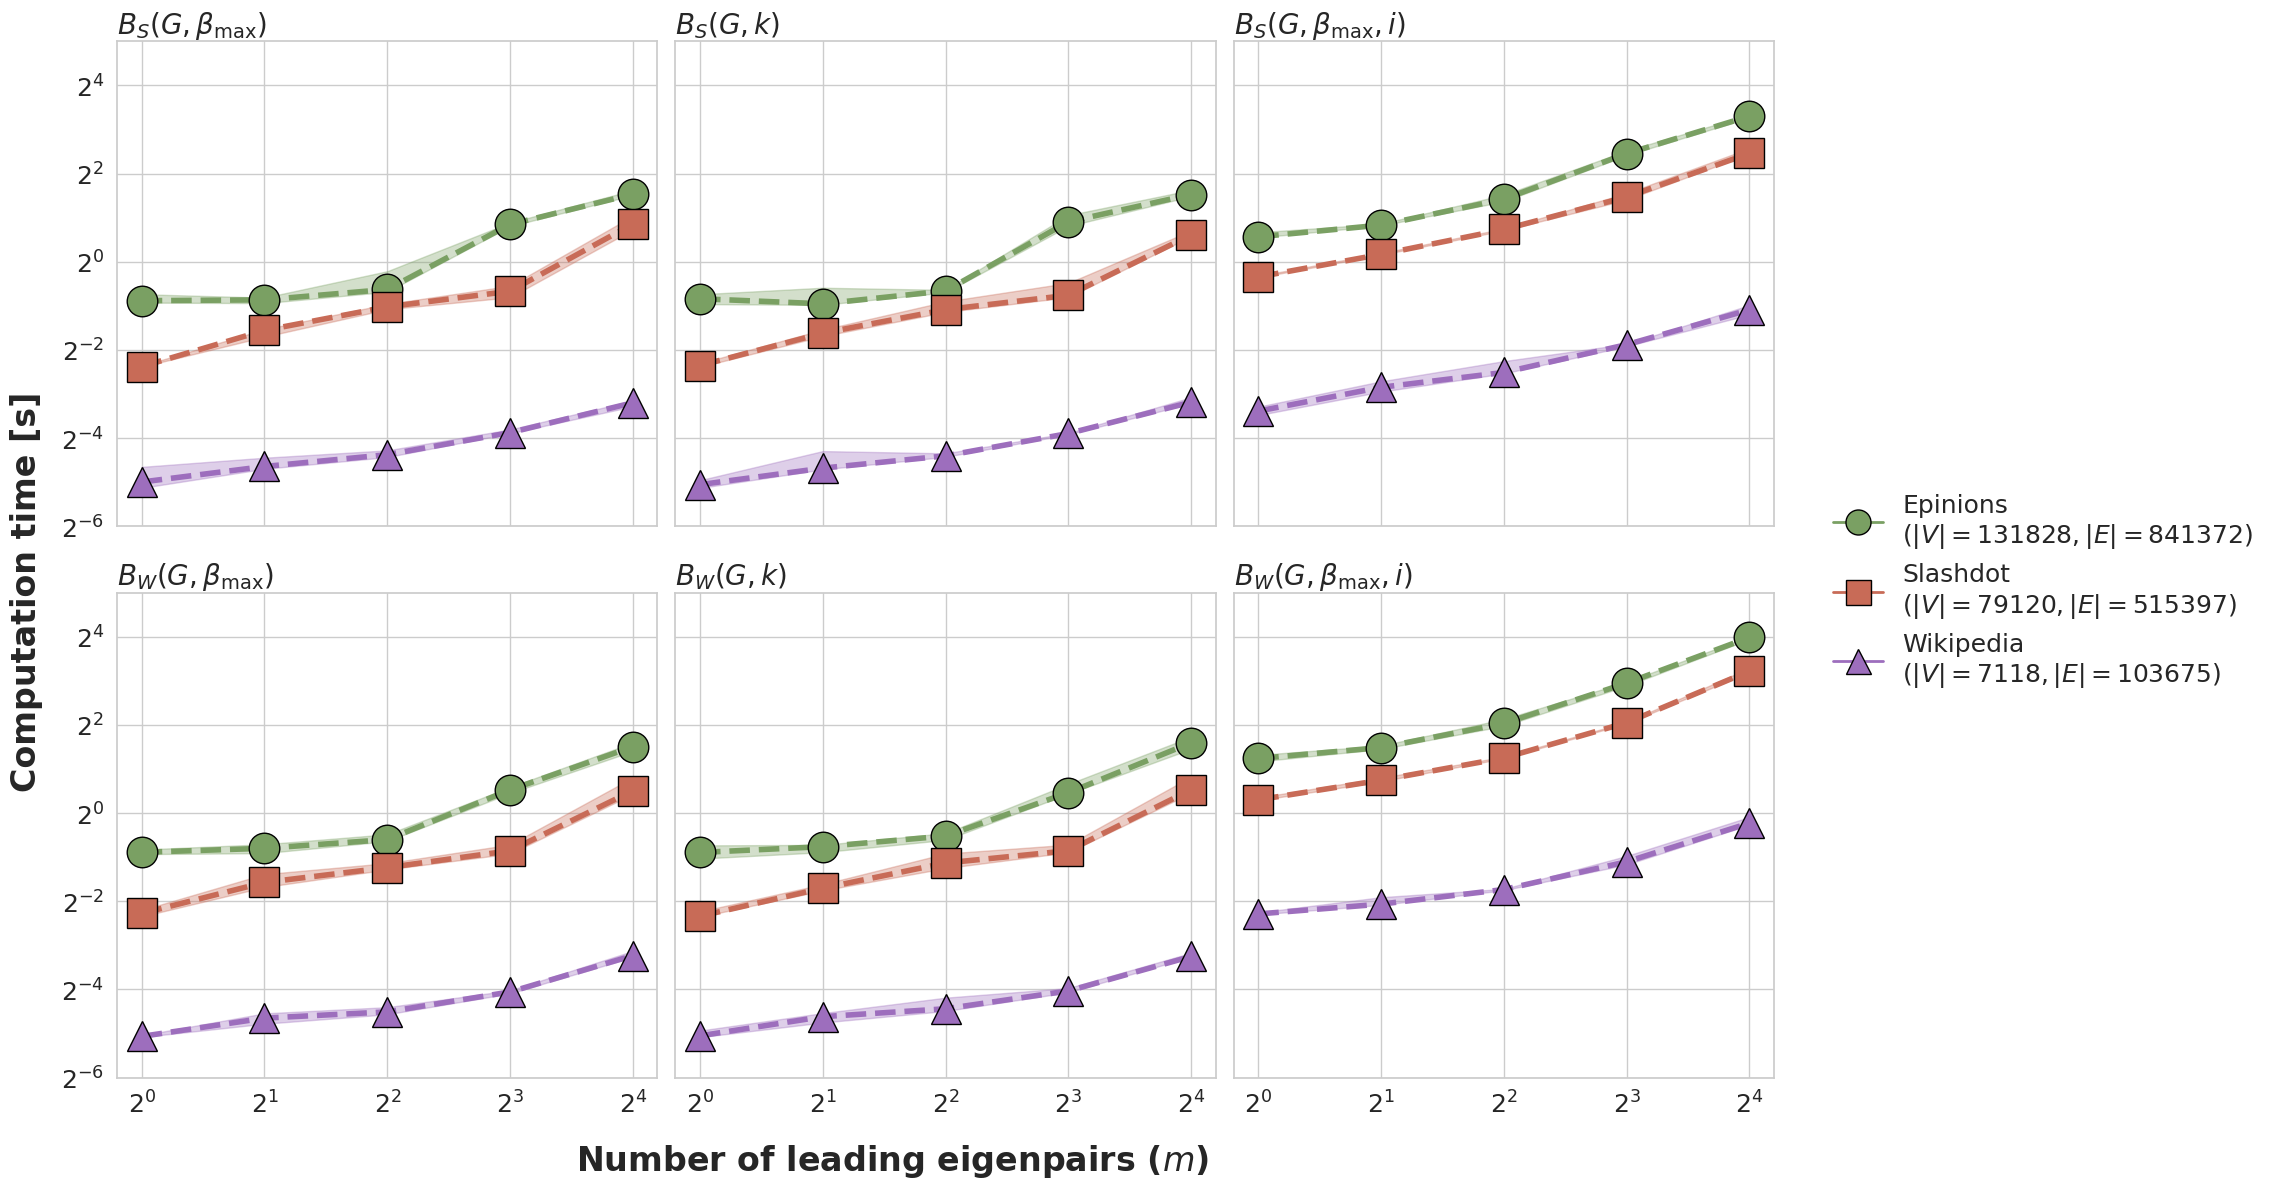

In [3]:
method_labels = {
    "balance": r"$B_S(G, \beta_{\max})$",
    "k_balance": r"$B_S(G, k)$",
    "node_balance": r"$B_S(G, \beta_{\max}, i)$"
}

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(18, 12))

labels = sdata.groupby("name")[["n_nodes", "n_edges"]] \
    .first() \
    .reset_index(drop=False) \
    .apply(lambda r: f"{r['name']}\n($|V|={r['n_nodes']}, |E|={r['n_edges']}$)", axis=1)
markers = ["o", "s", "^"]
colors = COLORS

regs = []
for axrow, mode, df in zip(axes, ["strong", "weak"], [sdata, wdata]):
    for ax, method in zip(axrow, METHODS):
        for opts in plt.cycler(
            gdf=df.groupby("name"),
            marker=markers,
            color=colors
        ):
            name, gdf = opts.pop("gdf")
            vals = gdf[method]
            lo = [ np.quantile(v, q=.1) for v in vals ]
            up = [ np.quantile(v, q=.9) for v in vals ]
            me = [ np.quantile(v, q=.5) for v in vals ]
            m = gdf["m"]
            kwds = { "markeredgecolor": "black", "markersize": 22, **opts }
            ax.fill_between(m, lo, up, color=opts["color"], alpha=.33)
            ax.plot(m, me, **kwds, lw=4, ls="--")
            ax.set_ylim(2**-6, 2**5)
            ax.set_xscale("log", base=2)
            ax.set_yscale("log", base=2)
            reg = linregress(np.log2(m), np.log2(me))
            regs.append(reg)
            title = method_labels[method]
            if mode == "weak":
                title = title.replace("_S", "_W")
            ax.set_title(title, x=0, fontsize=20, horizontalalignment="left")
            ax.tick_params(axis="both", which="both", labelsize=18)


handles = [
    mpl.lines.Line2D(
        [0], [0], color=color, lw=2, label=label,
        marker=marker, markeredgecolor="black", markersize=18
    ) for label, color, marker in zip(labels, colors, markers)
]
fig.legend(
    handles=handles, loc="center left", ncol=1,
    frameon=False, bbox_to_anchor=(1.01, .5), fontsize=18,
    facecolor=GRAY
)
for ax in axes[:, 1:].flat:
    ax.get_yaxis().set_ticklabels([])
for ax in axes[0, :].flat:
    ax.get_xaxis().set_ticklabels([])

fig.supxlabel(r"Number of leading eigenpairs ($m$)", fontsize=24, fontweight="bold")
fig.supylabel(r"Computation time [s]", fontsize=24, fontweight="bold", x=.01)
fig.tight_layout()
fig.savefig(FIGS/"perf-efficiency.pdf", bbox_inches="tight")